# Example of high-level interface

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
from tqdm import tqdm
from itertools import compress
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
NSAMPLES = 100000

## Toy generative model

In [3]:
def simulator(z):
    out = []
    for i in range(0, len(z), 2):
        r = ((z[i]-0.5)**2 + (z[i+1]-0.5)**2)**0.5
        mu = 1/(10*(r-0.2)**2+1e-2)
        out += [mu]
    x = np.random.poisson(out)
    return x

In [4]:
def noise(x, z):
    n = np.random.poisson(10., x.shape)
    return n + x

In [5]:
z0 = np.array([0.5, 0.7]*4)
zdim = len(z0)
x0 = noise(simulator(z0), z0)
comb1d = [[i] for i in range(zdim)]
comb2d = swyft.comb2d(range(zdim))
print(x0, z0)

[123 102 106 111] [0.5 0.7 0.5 0.7 0.5 0.7 0.5 0.7]


## Automatic inference 1-dim and 2-dim posteriors

In [6]:
ds = swyft.DataStore().init(zdim = zdim, xdim = x0.shape)
head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [7]:
re_prev = None
for r in range(1):
    td = swyft.TrainData(x0 = x0, zdim = zdim, noisehook = noise, datastore = ds, nsamples = NSAMPLES, threshold = 1e-6, parent = re_prev)
    ds.simulate(simulator)
    re = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb1d)
    re.train(max_epochs = MAX_EPOCHS, nbatch = 16, lr_schedule = [1e-3, 3e-4, 1e-4])
    re_prev = re

Constrained posterior area: 1.0
Adding 99839 new samples. Run simulator!


Simulate: 100%|██████████| 99839/99839 [01:27<00:00, 1143.95it/s]


Start training
LR iteration 0
Total epochs: 5
Validation losses: [20.61274403333664, 20.511001229286194, 20.45736062526703, 20.35180926322937, 20.42798602581024]
LR iteration 1
Total epochs: 4
Validation losses: [20.3722722530365, 20.34470307826996, 20.262916088104248, 20.354545295238495]
LR iteration 2
Total epochs: 4
Validation losses: [20.340180218219757, 20.25790500640869, 20.24375694990158, 20.313499629497528]


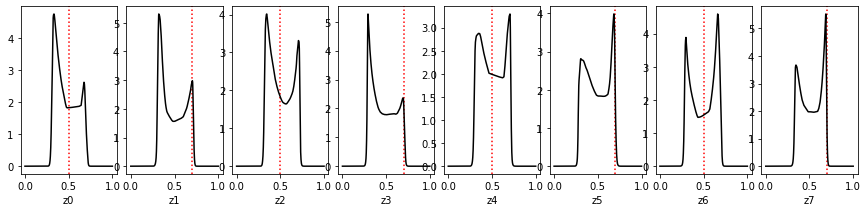

In [8]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (15, 3))

In [9]:
re2 = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb2d)

In [ ]:
re2.train(max_epochs = MAX_EPOCHS, nbatch = 16, lr_schedule = [1e-3, 3e-4, 1e-4])

Start training
LR iteration 0
Total epochs: 4
Validation losses: [65.28470957279205, 64.69575452804565, 63.70929181575775, 64.20262563228607]
LR iteration 1


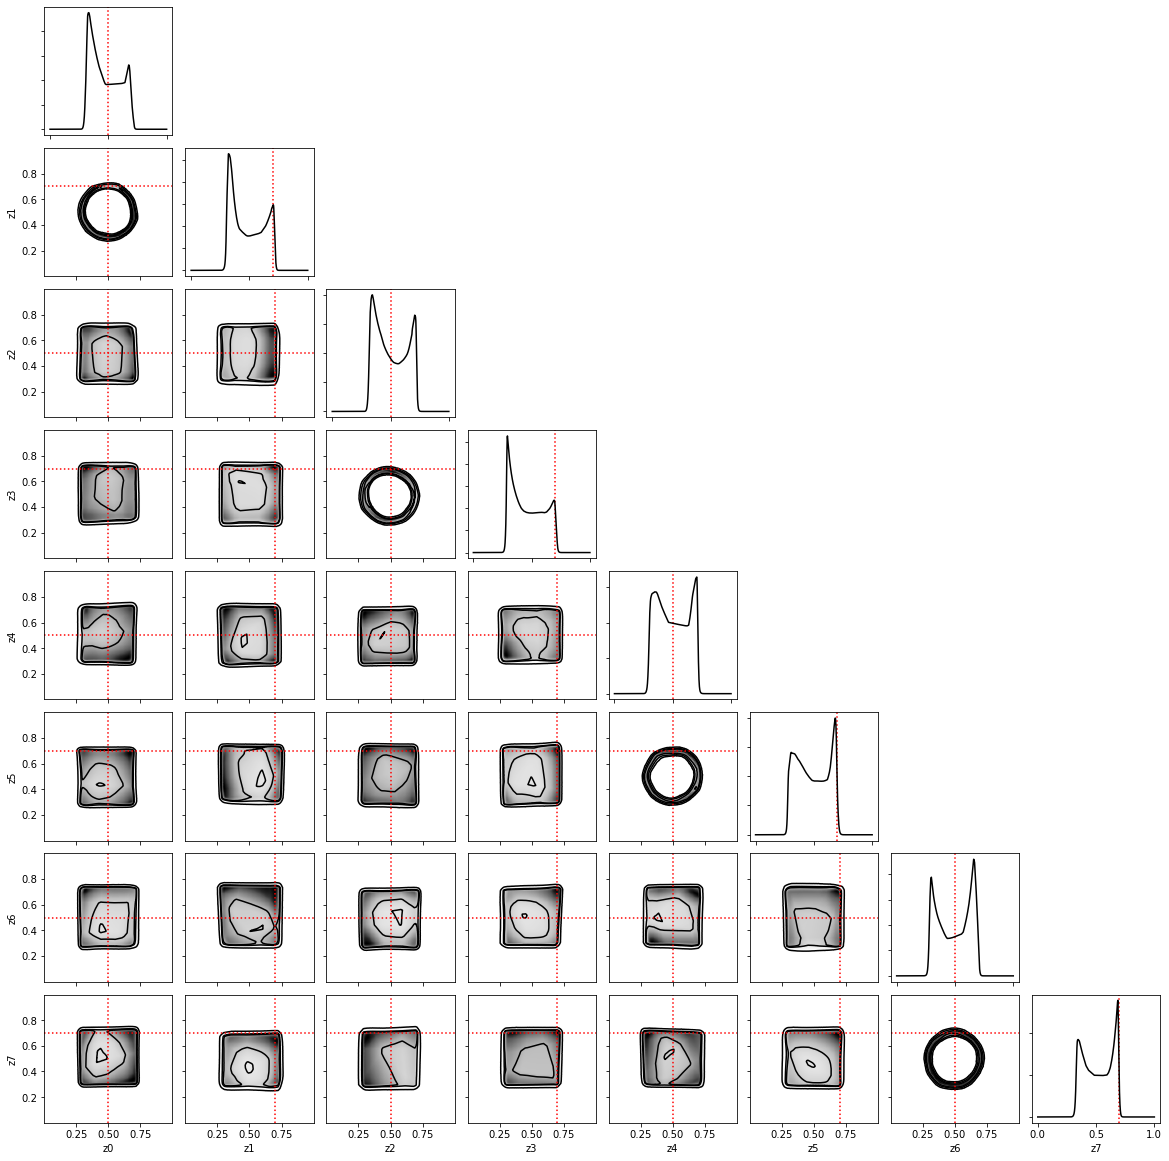

In [13]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 20)

In [ ]:
z0B = np.array([0.5, 0.8]*4)
x0B = noise(simulator(z0B), z0B)
swyft.corner(re, re2, x0 = x0B, z0 = z0B, cmap = 'Greys', dim = 20)

In [ ]:
z0B = np.array([0.5, 0.9]*4)
x0B = noise(simulator(z0B), z0B)
swyft.corner(re, re2, x0 = x0B, z0 = z0B, cmap = 'Greys', dim = 20)